## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

#  Подготовка

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [58]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [59]:
df.isna().sum()#посчитаем пропуски

num_orders    0
dtype: int64

In [60]:
df.sort_index(inplace=True)#отсортируем данные по индексу

In [61]:
df = df.resample('1H').sum()#проведем ресемплирование по одному часу.

In [62]:
df.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


In [63]:
df.index.is_monotonic, df.shape, df.index.min(), df.index.max()

(True,
 (4416, 1),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-08-31 23:00:00'))

Данные расположены в хронологическом порядке, охватывающие период с 01.03.2018 по 31.08.2018.

Подготовим еще один датасет с ресемплированием в 1 сутки 

In [64]:
days=  pd.DataFrame(df['num_orders'].resample('1D').sum())

In [65]:
days.head(3)

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290


In [66]:
df.shape, days.shape

((4416, 1), (184, 1))

Таким образом мы получили два датасета отражающие почасовое и посуточное количество заказов, расположенных в хронологическом порядке с 1 марта 2018 по 31 августа 2018 года. 

#  Анализ

### Нелинейность 

Проанализируем наши временные ряды на линейность. 
Построим графики кол-ва заказов, среднесуточного сумарного заказа и стандартного отклонения. 

Text(0.5, 1.0, 'num_orders')

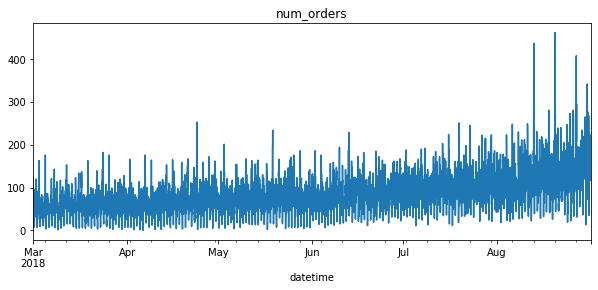

In [67]:
df['num_orders'].plot(figsize=(10, 4));
plt.title('num_orders')

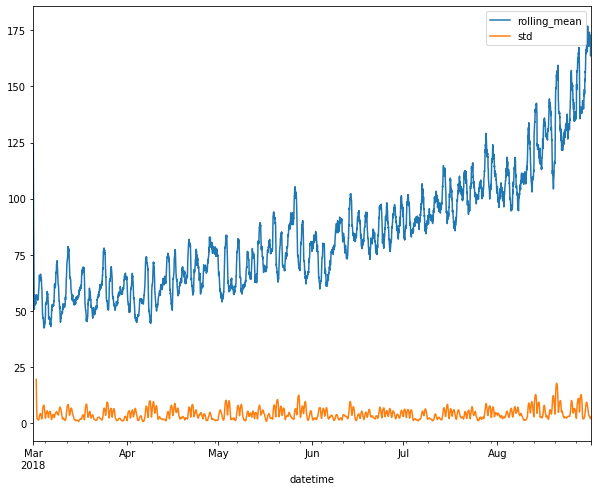

In [68]:
df['rolling_mean'] = df.rolling('1D').mean()
df['std'] = df['rolling_mean'].rolling(24).std()
df[['rolling_mean','std']].plot(figsize=(10, 8));

Скользящее среднее имеет повышюящийся тренд. Стандартное отклонение не имеет тренда и колеблется возле одного значения. Таким образом мы имеем стохастический нестационарный ряд

### Сезонность 

Изучим наш ряд на имеющиеся сезонности. Для этого проведем декомпозицию часового и суточного временных рядов. 

Часовой ряд:

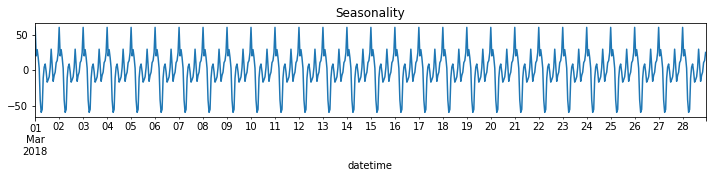

In [69]:
decomposed = seasonal_decompose(df['num_orders'])  
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-28'].plot(ax=plt.gca(),figsize=(10,6))
plt.title('Seasonality')
plt.tight_layout()

Суточный ряд:

Text(0.5, 1.0, 'Seasonality')

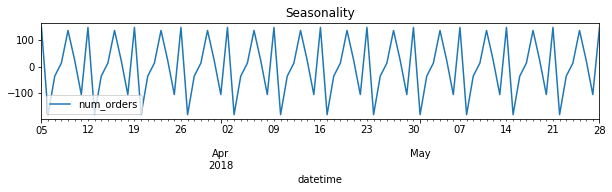

In [70]:
decomposed_day = seasonal_decompose(days)
plt.figure(figsize=(6, 8))
plt.subplot(312)
decomposed_day.seasonal['2018-03-05':'2018-05-28'].plot(ax=plt.gca(),figsize=(10,6))
plt.title('Seasonality')

  И так мы обнаружили две сезонности - внутрисуточную и внутринедельную. Это значит что каждый час через неделю значения целевого признака повторяются  с большой точностью

### Дополнитеольные признаки

Предположим что наша система получает данные каждый час и доложна сделать предсказание на следующий час, т.е. если сейчас 23 часа вечера и нам нужно предсказать сколько потребуется такси через час (к 24 часам). У нас есть данные на 23 часа сегодняшнего дня и все предыдущие измерения. 

Первым признаком будет  значение , которое будет равно значению временного ряда со свдигом в неделю от предпологаемого значения 

In [71]:
df['super_lag'] = df['num_orders'].shift(168)

Создадим несколько  признаков, которые бы отражали текущую динамику. Затем отберем, те которые наиболее всего влияют на целевой признак. К таким признакам можно отнести предыдущие значения (сдвиг), разность между двумя предыдущими значениями и скользящее среднее 

In [72]:
# Функция создает признаки: сдвиги, разности и скользящее среднее значение
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)#последнее измеренное значение и предыддущие
        data['shift_{}'.format(lag)]  = data['num_orders'].shift() - data['num_orders'].shift(lag+1)#разница между последним измеренным значением и предыдущими

    data['rolling_mean'] = data['num_orders'].shift().rolling( rolling_mean_size).mean()

In [73]:
make_features(df,7, 7)

In [74]:
df.head(5)

,num_orders,rolling_mean,std,super_lag,dayofweek,lag_1,shift_1,lag_2,shift_2,lag_3,shift_3,lag_4,shift_4,lag_5,shift_5,lag_6,shift_6,lag_7,shift_7
datetime,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,NaN,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,NaN,3,85.0,-39.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,NaN,3,71.0,-14.0,85.0,-53.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,NaN,3,66.0,-5.0,71.0,-19.0,85.0,-58.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В результате анализа мы выявили что ряд подчиняется одновременно двум циклам - суточный ритм и недельный ритм. 
Что бы отразить цикличность в датасете мы ввели дополнительный признак, который равен значению взятому ровно неделю назад. 
Так же что бы операться на текущую динамику ввели признаки - среднее скользящее, сдвиги и разности, которые рассчитываются от последнего измеренного значения целевого признака

#  Обучение

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV 
import lightgbm as lgb
import time
import seaborn as sns

Разделим датасет на тренировочную и тестовую выборку. 

In [76]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
features_train =  train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test =  test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Линейная регрессия 

In [77]:
model = LinearRegression()
model.fit(features_train, target_train)
predicted_train = model.predict(features_train)
mse = mean_squared_error(target_train, predicted_train)
print("RMSE =", mse** 0.5)

RMSE = 23.505398843003352


Линейная регрессия на тренировочной выборке показала RMSE - 23.48

### Градиентный бустинг

Для градиентного бустинга обратимся к алгоритму LightGBM

In [78]:
#через GridSearchCV отберем наиболее подходящие гиперпароаметры
lgbm_model = LGBMRegressor(boosting_type = 'gbdt',objective ='regression')

param = {
             'learning_rate': [0.05,0.2,0.5,0.9], 
             'max_depth': [2,4,8] 
           }
gs = GridSearchCV(lgbm_model , param, scoring='neg_mean_squared_error', cv=3)
gs.fit(features_train, target_train);

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.05, 'max_depth': 4}

In [80]:
lgbm_model = LGBMRegressor(boosting_type = 'gbdt',objective ='regression',learning_rate= 0.2, max_depth =8)
lgbm_model.fit(features_train, target_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.2, max_depth=8,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [81]:
predicted_train = lgbm_model.predict(features_train)
mse = mean_squared_error(target_train, predicted_train)
print("RMSE =", mse** 0.5)

RMSE = 12.512071926481278


На тренировочной выборке  бустинг показал RMSE  - 12.46

### Отбор значимых признаков

,feature,importance
2,super_lag,202
17,shift_7,178
0,rolling_mean,163
6,lag_2,156
5,shift_1,144
1,std,142
13,shift_5,141
12,lag_5,140
7,shift_2,131
10,lag_4,126


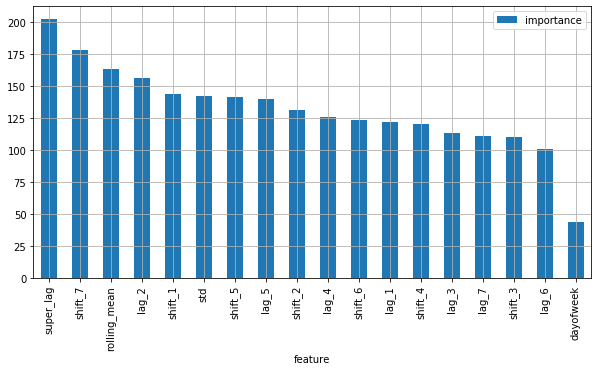

In [82]:
fi = pd.DataFrame({'feature': list(features_train.columns),
                   'importance': lgbm_model.feature_importances_}).sort_values('importance', ascending = False)

fi.plot(kind='bar', y='importance',grid=True, figsize=(10,5), x= 'feature' )
fi

Самый значимый признак это - super_lag. Что подтверждает двойную цикличность работы аэропорта (суточный ритм и недельный ритм).
Остальные признаки плавно снижаются в значимости. 

И так мы обучили две модели - линейную регрессию и градиентный бустинг, на тренировочной выборке бустинг показывает в двое лучший результат
Посмотрим как модели справятся с тестовой выборкой. 

#  Тестирование

Протестируем линейную регрессию 

In [83]:
predicted_test = model.predict(features_test)
mse = mean_squared_error(target_test, predicted_test)
print("RMSE =", mse** 0.5)

RMSE = 37.226779308099914


In [84]:
data = pd.DataFrame({'target': target_test,'predict':predicted_test, 'error':(predicted_test -target_test)})

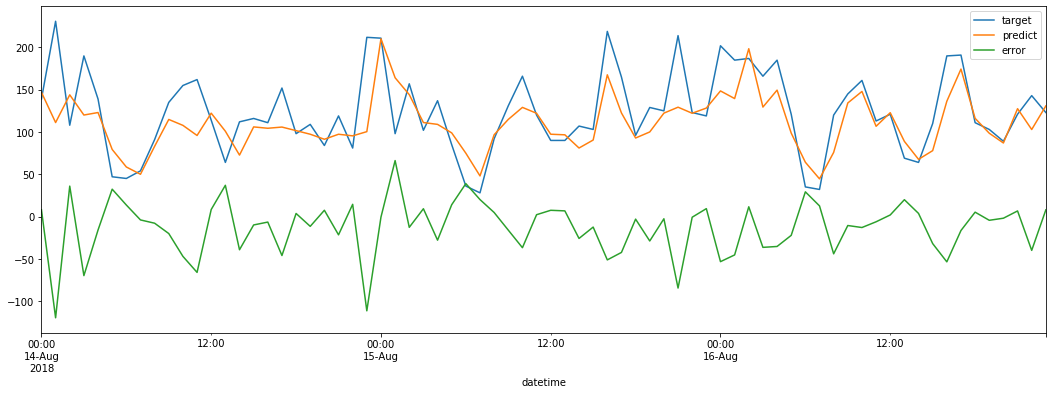

In [86]:
data['2018-08-14':'2018-08-16'].plot(figsize=(18,6))

Протестируем градиентный бустинг

In [87]:
predicted_test = lgbm_model.predict(features_test) 
mse = mean_squared_error(target_test, predicted_test)
print("RMSE =", mse** 0.5)

RMSE = 43.67945008235633


In [88]:
data = pd.DataFrame({'target': target_test,'predict':predicted_test, 'error':(predicted_test-target_test) })

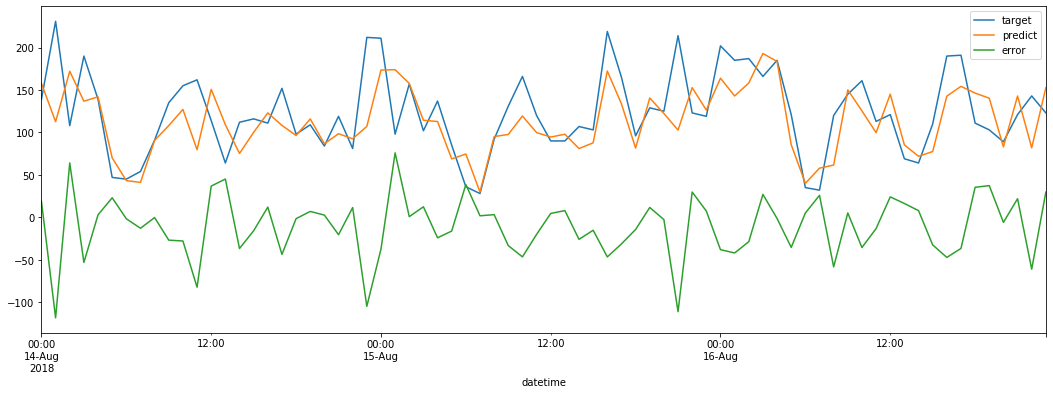

In [108]:
data['2018-08-14':'2018-08-16'].plot(figsize=(18,6))

Наиболе крупные ошибки модель допускает в районе 12 ночи +- 2 часа. 

# Вывод

Аэропорт подчиняющийся двум ритмам организм - суточный и недельный.
Несмотря  на повышающийся тренд эти два ритма являются определяющим значением для потока пассажиров
Обучены две модели для предсказания линейная регрессия и градиентный бустинг. 
Наиболе точно предсказывает линейная регрессия. Точность предсказания- 37 машин. 
Цель проекта достигнута. 